In [3]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import requests
import pandas as pd
from bs4 import BeautifulSoup
import re
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import zillow
import re
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import json
import geog
import shapely.geometry
from zillow import ValuationApi

pd.options.display.max_rows = 700

In [4]:
df = pd.read_csv('./us/nj/morris.csv')

In [5]:
def circle_area(long,lat,radius,n_points):
    p = shapely.geometry.Point([long, lat])
    angles = np.linspace(0, 360, n_points)
    d = radius
    polygon = geog.propagate(p, angles, d)
    df_test = pd.DataFrame(polygon)
    polygon = shapely.geometry.mapping(shapely.geometry.Polygon(polygon))
    df_test.plot(x = 0, y = 1, kind = 'scatter')
    return polygon

{'type': 'Polygon',
 'coordinates': (((-74.4988141470866, 40.67881999393376),
   (-74.49887839495527, 40.67911200382137),
   (-74.49906418767353, 40.67937237098539),
   (-74.4993513926078, 40.679572880086894),
   (-74.49970888651269, 40.67969180223836),
   (-74.50009792827403, 40.67971624992531),
   (-74.5004763575748, 40.67964357375993),
   (-74.50080316429671, 40.679481649626176),
   (-74.50104293320668, 40.67924802508171),
   (-74.50116968202256, 40.67896801756934),
   (-74.50116967682803, 40.678671970626866),
   (-74.5010429198137, 40.678391965534125),
   (-74.50080314835336, 40.67815834480853),
   (-74.5004763458047, 40.677996424282384),
   (-74.50009792564084, 40.67792374999195),
   (-74.4997088941269, 40.677948197030496),
   (-74.49935140725833, 40.67806711628365),
   (-74.49906420318197, 40.67826762145919),
   (-74.49887840478145, 40.678527985325275),
   (-74.4988141470866, 40.67881999393376)),)}

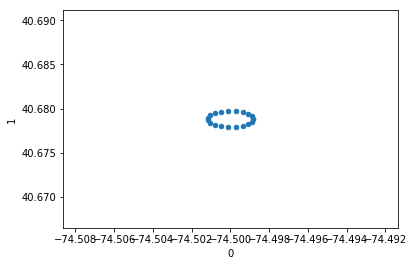

In [7]:
polygon =circle_area(-74.5,40.67882,100,n_points=20)
poly = Polygon(polygon['coordinates'][0])

polygon

Cleaning required for this specific dataset includes specifically adding zeros to the postal codes.  To do this propertly you must convert the float, to an int then a string and apply a lambda function to all the values in the dataframe.

In [5]:
df.drop(['DISTRICT','REGION','ID','HASH','UNIT'], axis = 1, inplace = True)
df.dropna(inplace = True)
df.reset_index(inplace = True)
df['POSTCODE'] = df['POSTCODE'].astype(int)
df['POSTCODE'] = df['POSTCODE'].astype(str)


In [6]:
df['POSTCODE'] = df['POSTCODE'].apply(lambda x: x.zfill(5))

Instantiate the progress bar, this helps keep and eye on the for loops as they run.  You will likely have to rerun the bar function for whatever reason.

In [7]:
from progressbar import ProgressBar
bar = ProgressBar(poll_interval=1)

In [8]:
pointlist = []
for i in bar(range(len(df))):
    pointlist.append(Point(df['LON'].iloc[i],df['LAT'].iloc[i]))

100% (203620 of 203620) |################| Elapsed Time: 0:00:12 Time:  0:00:12


In [9]:
bar = ProgressBar(poll_interval=1)

In [10]:
temp_list = []
for i in bar(pointlist):
        if poly.contains(i) == True:
            temp_list.append(df.iloc[pointlist.index(i)])
print(temp_list)

100% (203620 of 203620) |################| Elapsed Time: 0:00:14 Time:  0:00:14


[index           6468
LON         -74.4996
LAT          40.6783
NUMBER           383
STREET       HIGH ST
CITY        STIRLING
POSTCODE       07980
Name: 6439, dtype: object, index           8212
LON         -74.4991
LAT          40.6793
NUMBER           362
STREET       HIGH ST
CITY        STIRLING
POSTCODE       07980
Name: 8176, dtype: object, index          18218
LON         -74.5004
LAT          40.6787
NUMBER           396
STREET       HIGH ST
CITY        STIRLING
POSTCODE       07980
Name: 18135, dtype: object, index          24287
LON         -74.4995
LAT          40.6791
NUMBER           368
STREET       HIGH ST
CITY        STIRLING
POSTCODE       07980
Name: 24165, dtype: object, index          91484
LON         -74.5009
LAT          40.6785
NUMBER           404
STREET       HIGH ST
CITY        STIRLING
POSTCODE       07980
Name: 91016, dtype: object, index          95933
LON            -74.5
LAT          40.6789
NUMBER           384
STREET       HIGH ST
CITY        STIRLING


In [11]:
from zillow import ValuationApi

#insert your API key from zillow here
zid = 'X1-ZWz18cqbc8wgsr_7j3qs'

api = zillow.ValuationApi()

In [12]:
zdf = pd.DataFrame(temp_list)
zdf.reset_index(inplace = True)

In [15]:
from progressbar import ProgressBar
bar = ProgressBar(poll_interval=1)

In [13]:
def Zestimate():
    zestimate_list = []
    #zipdf = df[df['POSTCODE'].isin(zipcode)]
    zipdf = zdf

    for i in bar(range(len(zipdf))):
        try:
            address = str(zipdf['NUMBER'][i].astype(str)+' '+zipdf['STREET'][i]+'.,'+zipdf['CITY'][i]+', NJ')
            postal_code = zipdf['POSTCODE'][i]
            data = api.GetSearchResults(zid,address,postal_code)
            if data != None:
                zestimate_list.append(data.zestiamte.amount)
            else:
                pass
        except:
            pass
    #Worth noting that many of the addresses do no have corresponding values in the zillow database.
    #The below print output shows how many the API missed.
    print('Missing Values:',len(zipdf)-len(zestimate_list),'Gathered %:',(len(zestimate_list))/len(zipdf))
    
    # This is the print output, change the print out to your preference.
    zestimate_list = [x for x in zestimate_list if x is not None]
    zestimate_list = np.array(zestimate_list)
    statistics = stats.describe(zestimate_list)
    std = np.std(zestimate_list)
    median = np.median(zestimate_list)
    print('    ==========================================')
    print('                 For Area', )
    print('    ==========================================')
    print()
    print('     |  Values  |:',statistics[0])
    print('     | Minimum  |:', statistics[1][0])
    print('     | Maximum  |:', statistics[1][1])
    print('     |  Median  |:', median)
    print('     |   Mean   |:', float("{0:.2f}".format(statistics[2])))
    print('     |   Std    |:', float("{0:.2f}".format(std)))
    print('     | Skewness |:', float("{0:.2f}".format(statistics[4])))
    print('     | Kurtosis |:', float("{0:.2f}".format(statistics[5])))
    plt.hist(zestimate_list, edgecolor = 'black');
    plt.xlabel('House Value')
    plt.ylabel('Frequency')
    return 

100% (7 of 7) |##########################| Elapsed Time: 0:00:02 Time:  0:00:02


Missing Values: 0 Gathered %: 1.0
                 For Area

     |  Values  |: 7
     | Minimum  |: 458294
     | Maximum  |: 864980
     |  Median  |: 773502.0
     |   Mean   |: 710443.14
     |   Std    |: 160772.1
     | Skewness |: -0.75
     | Kurtosis |: -1.16


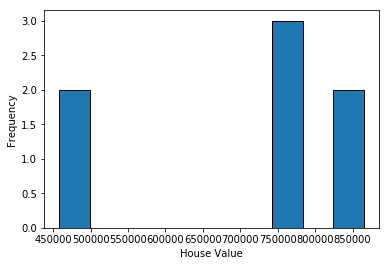

In [16]:
Zestimate()

In [ ]:
#Need to change the number values to dollar k